# 04 DAG

DAG is short for "directed acyclic graph". 

A DAG can represent the causal relation between factors.

L has causal effect on A and Y. Also, A has causal effect on Y.


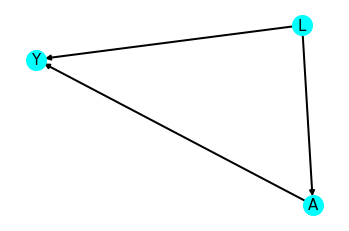

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(nodes, edges, seed = 0, color = 'aqua', title = ''):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    pos = nx.spring_layout(G, seed = seed)
    nx.draw_networkx_nodes(G, pos, node_size=400, node_color = color)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=2)
    nx.draw_networkx_labels(G, pos, font_size=15, font_family="sans-serif", font_color="black")
    plt.title(title)
    plt.axis("off")
    plt.show()

# Define nodes
nodes = ['L', 'A', 'Y']

# Define edges
edges = [('L', 'A'), ('A', 'Y'), ('L', 'Y')]

# Draw graph
print('L has causal effect on A and Y. Also, A has causal effect on Y.')
draw_graph(nodes, edges)

## DAG

### Complete DAG

If for an DAG there is an edge between each pair of nodes, it is a complete DAG.

Since a DAG has no cycle, a complete DAG must be in the form of, up to a permutation of nodes, $v_i\rightarrow v_j$ for all $j>i$.

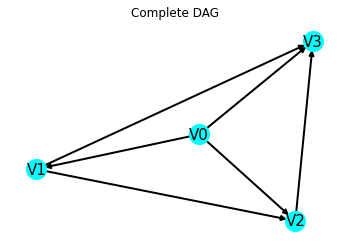

In [2]:
nodes = ['V%d'%i for i in range(4)]
edges = []
for i in range(4):
    for j in range(i+1, 4):
        edges.append(('V%d'%i, 'V%d'%j))

draw_graph(nodes, edges, seed = 1, title = 'Complete DAG')

### Statistical DAG

A DAG can represent a statistical distribution model. When assuming **Markov factorization**, the density of DAG is the product of probability density of each node, conditioned on its direct parents.

<IPython.core.display.Math object>

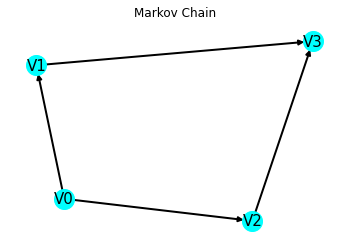

In [3]:
def compute_distribution(nodes, edges):
    G = nx.DiGraph()
    G.add_nodes_from(nodes)

    # reverse the edges to trace the parents
    G.add_edges_from([(e[1], e[0]) for e in edges])
    
    s = 'f(v) = '
    for v in G.nodes():
        parents = list(G.neighbors(v))
        s += 'f(%s|%s)'%(v, ','.join(parents)) if len(parents) else 'f(%s)'%v
    
    from IPython.display import display, Math
    display(Math(s))
    return s

nodes = []
edges = [('V0','V1'), ('V0', 'V2'), ('V1', 'V3'), ('V2', 'V3')]

compute_distribution(nodes, [('v_'+e1[1], 'v_'+e2[1]) for e1, e2 in edges])
draw_graph(nodes, edges, seed = 1, title = 'Markov Chain')

## Conditional Independence

We introduce some terminology.

### Path

For two nodes $A,B$, any sequence of distinct nodes $A,v_1,v_2,\cdots,v_n,B$ so that there is an edge between two adjacent nodes is a path from $A$ to $B$. <font color=red>The direction of each edge does not matter</font>.

As an example, a DAG $(A\rightarrow B, C\rightarrow B, A\rightarrow C)$ has two paths from $A$ to $C$: $\quad $ $A\rightarrow B\leftarrow C$ and $A\rightarrow C$.

### Causal Path 

Causal path is a path that has correct arrow direction. For instance, $A\rightarrow B\rightarrow C\rightarrow D$ is a causal path from $A$ to $D$.

### Collider

For a path, if there are three adjacent nodes $v_{i-1}\rightarrow v_i\leftarrow v_{i+1}$, then $v_i$ is a collider.

For instance, $B$ is a collider of the path $A\rightarrow B\leftarrow C$.

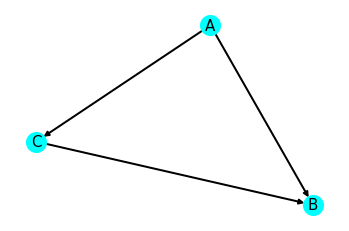

In [4]:
draw_graph([], [('A', 'B'), ('C', 'B'), ('A', 'C')])

### Conditioning

Now we want to study the conditional distribution with some factors being conditioned on.

Denote $C$ to be the set of conditioned factors. 

<br>

### Blocked Paths

A path is blocked if one of the following two conditions holds: [[Ref](https://imai.fas.harvard.edu/teaching/files/DAG.pdf)]

1. A factor on the path is in $C$ but not a collider.
2. A factor on the path is a collider, not in $C$, and is not direct descendant of colliders in $C$.


Conversly, a path is unblocked if it is not blocked.

### Conditional Independence

Two factors $A,B$ are conditionally independent given $C$ if there is no unblocked path from $A$ to $B$. We denote it as $A\perp\!\!\!\perp B\ | C$. It is also called d-separated.



Conditioning on vertex C: Then B is a non-conditioned collider descendant to C.
So the path from A to D is blocked.


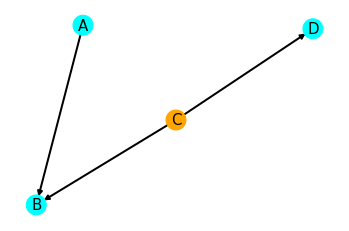

In [5]:
print('Conditioning on vertex C: Then B is a non-conditioned collider descendant to C.\nSo the path from A to D is blocked.')
draw_graph([], [('A', 'B'), ('C', 'B'), ('C', 'D')], seed = 1, color = ['aqua', 'aqua', 'orange', 'aqua'])

In [6]:
def check_blocked(path, arrows, conditioned, verbose = ''):
    """
    Check whether a path is conditionally blocked.
    Path is a list of node names. 
    Arrows is a list of boolean values. 1: ->, 0: <-.
    Conditioned is a boolean dictionary of node names.
    """
    c = lambda x: '[%s]'%x if conditioned.get(x, 0) else x
    path_name = ' '.join(c(v) + (' ->' if arrow else ' <-') 
                            for v, arrow in zip(path, arrows)) + ' ' + path[-1]
    for i in range(1, len(path) - 1):
        if conditioned.get(path[i], 0): # conditioned on
            if not (arrows[i-1] == 1 and arrows[i] == 0): # noncollider
                if verbose is not None:
                    print(verbose + path_name, 
                          'is blocked because %s is a conditioned nonclider.'%path[i])
                return True
        else: # not conditioned on
            if arrows[i-1] == 1 and arrows[i] == 0: # collider
                if conditioned.get(path[i-1], 0) == 0 and\
                        conditioned.get(path[i+1], 0) == 0: 
                    # no descendent to conditioned vertices         
                    if verbose is not None:
                        print(verbose + path_name, 
                              'is blocked because %s is a collider and'%path[i]
                              + ' no descendent to conditioned vertices.')
                    return True
    
    if verbose is not None:
        print(verbose + path_name, 'is not blocked.')
    return False

def get_all_paths(nodes, edges, A, B, conditioned = {}, verbose = None):
    """
    Get all paths from A to B.
    Also return the arrow directions.
    """
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    paths = list(nx.all_simple_paths(G, A, B))

    edges = dict.fromkeys(edges)
    arrows = []
    for path in paths:
        arrows.append([])
        for i in range(len(path) - 1):
            arrows[-1].append(1 if (path[i], path[i+1]) in edges else 0)

    is_blocked = True
    for path, arrow in zip(paths, arrows):
        is_blocked2 = check_blocked(path, arrow, conditioned = conditioned, verbose = verbose)
        is_blocked = is_blocked and is_blocked2

    if verbose is not None:
        print('\033[0;3%cmConditioning on %s is %s.\033[0m'%(
            '1' if is_blocked else '5', conditioned, 'blocked' if is_blocked else 'not blocked'))
    return paths, arrows, is_blocked

W -> Z <- U -> T <- X -> Y is blocked because Z is a collider and no descendent to conditioned vertices.
W -> Z <- U -> T -> Y is blocked because Z is a collider and no descendent to conditioned vertices.
W -> Z -> X -> T -> Y is not blocked.
W -> Z -> X -> Y is not blocked.
Conditioning on {} is not blocked.


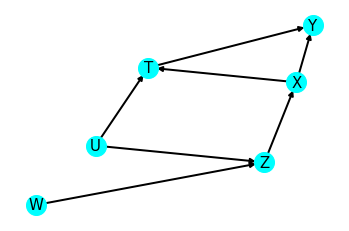

In [7]:
edges = [('W','Z'),('U','Z'),('U','T'),('Z','X'),('X','T'),('T','Y'),('X','Y')]
get_all_paths([], edges, 'W', 'Y', verbose = '')
draw_graph([], edges, seed = 1)

In [10]:
from itertools import product

for cond in product(range(2), repeat = 4):
    cond = dict(zip(['U', 'Z', 'X', 'T'], cond))
    get_all_paths([], edges, 'W', 'Y', conditioned = cond, verbose = '    ')

    W -> Z <- U -> T <- X -> Y is blocked because Z is a collider and no descendent to conditioned vertices.
    W -> Z <- U -> T -> Y is blocked because Z is a collider and no descendent to conditioned vertices.
    W -> Z -> X -> T -> Y is not blocked.
    W -> Z -> X -> Y is not blocked.
Conditioning on {'U': 0, 'Z': 0, 'X': 0, 'T': 0} is not blocked.
    W -> Z <- U -> [T] <- X -> Y is blocked because Z is a collider and no descendent to conditioned vertices.
    W -> Z <- U -> [T] -> Y is blocked because Z is a collider and no descendent to conditioned vertices.
    W -> Z -> X -> [T] -> Y is blocked because T is a conditioned nonclider.
    W -> Z -> X -> Y is not blocked.
Conditioning on {'U': 0, 'Z': 0, 'X': 0, 'T': 1} is not blocked.
    W -> Z <- U -> T <- [X] -> Y is blocked because Z is a collider and no descendent to conditioned vertices.
    W -> Z <- U -> T -> Y is blocked because Z is a collider and no descendent to conditioned vertices.
    W -> Z -> [X] -> T -> Y is b

### Backdoor Criterion

Given two nodes $A,B$. If we want to study the impact of $A$ on $B$, we must block all the backdoor paths. 

For example, if there is a node $C$ such that $C\rightarrow A$ and $C\rightarrow B$, then $C$ is a backdoor path from $A$ to $B$.


A set of variables that controls the backdoor paths from $A$ to $B$ is a set of nodes $X$ such that:

1. No vertex in $X$ lies on any causal path from $A$ to $B$.
2. Conditioning on $X$ blocks all paths from $A$ to $B$ with incoming arrow to $A$.

In [49]:
def check_blocks_backdoor(nodes, edges, A, B, X, verbose = None):
    """
    Check whether X blocks the backdoor path from A to B.
    """
    if not isinstance(X, dict):
        X = dict.fromkeys(X, 1)
    paths, arrows, is_blocked = get_all_paths(nodes, edges, A, B, verbose = None)
    is_blocked = True
    for path, arrow in zip(paths, arrows):
        # only consider paths with incoming arrow to A
        if arrow[0] == 0:
            is_blocked2 = check_blocked(path, arrow, conditioned = X, verbose = verbose)
            is_blocked = is_blocked and is_blocked2

        if all(_ for _ in arrow):
            # causal path
            for v in path:
                if v in X:
                    # path contains conditioned vertex
                    if is_blocked and (verbose is not None):
                        print('%s lies on a causal path from %s to %s.'%(v, A, B))
                    is_blocked = False
        
    if verbose is not None:
        print('\033[0;3%cm%s can%s control backdoor paths from %s to %s.\033[0m'%(
            '1' if is_blocked else '5', list(X.keys()), '' if is_blocked else 'not', A, B))
    return False

T <- U -> [Z] -> Y is blocked because Z is a conditioned nonclider.
T <- U -> X <- Y is blocked because X is a collider and no descendent to conditioned vertices.
T <- [Z] <- U -> X <- Y is blocked because Z is a conditioned nonclider.
T <- [Z] -> Y is blocked because Z is a conditioned nonclider.
['Z'] can control backdoor paths from T to Y.


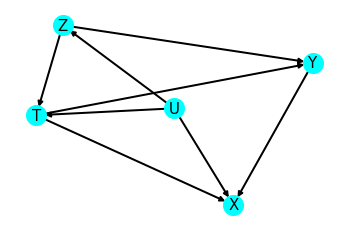

In [51]:
edges = [('U','Z'),('U','T'),('U','X'),('Z','T'),('Z','Y'),('T','X'),('T','Y'),('Y','X')]
check_blocks_backdoor([], edges, 'T', 'Y', ['Z'], verbose = '')
draw_graph([], edges, seed = 6)

E <- [A] -> [B] <- S -> D is blocked because A is a conditioned nonclider.
E <- [A] -> [B] -> D is blocked because A is a conditioned nonclider.
E <- [B] <- S -> D is blocked because B is a conditioned nonclider.
E <- [B] -> D is blocked because B is a conditioned nonclider.
['A', 'B'] can control backdoor paths from E to D.


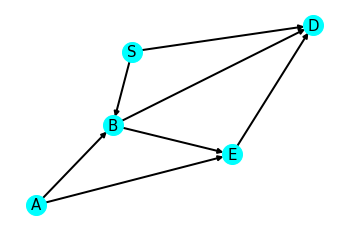

In [55]:
edges = [('A','B'),('A','E'),('S','B'),('S','D'),('B','E'),('B','D'),('E','D')]
check_blocks_backdoor([], edges, 'E', 'D', ['A', 'B'], verbose = '')
draw_graph([], edges, seed = 1)